# Heart Attack Prediction
###### Using data from https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease
###### The goal is to use decision trees to predict whether someone will have a heart attack.
###### Performance will be compared between different parameters and approaches.

In [22]:
# Import libraries and data
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
data = pd.read_csv("heart_2022_no_nans.csv")
data

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,Virgin Islands,Male,Very good,0.0,0.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,No,...,1.78,102.06,32.28,Yes,No,No,No,"Yes, received tetanus shot but not sure what type",No,No
246018,Virgin Islands,Female,Fair,0.0,7.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.93,90.72,24.34,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes
246019,Virgin Islands,Male,Good,0.0,15.0,Within past year (anytime less than 12 months ...,Yes,7.0,1 to 5,No,...,1.68,83.91,29.86,Yes,Yes,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,Yes
246020,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.70,83.01,28.66,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No


##### Data Preprocessing
###### SciKit learn trees can only handle numbers, so all values must be converted.
##### Numeric Values
###### Floats and integers are fine as is. There is no need to scale or bin them.
##### Binary Values
###### Yes/No and Male/Female are converted to 1 and 0.
##### Range Values
###### Values that can be converted to a range of numbers where the difference between them has meaning.
###### Ex. General Health. Poor to Excellent can be represented as 0-4.
##### Categorical Values
###### These must be represented using a one-hot encoding.
###### Ex. States have no numerical relation to each and there are far more than 2.

In [2]:
# Basic stats of numerical data
display(data.describe())

# Preprocessing - Store numeric values
numeric_columns = ["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"]
numeric_entries = data[numeric_columns].to_numpy()
print("Shape:",numeric_entries.shape)
numeric_entries

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,246022.000000,246022.000000,246022.000000,246022.000000,246022.000000,246022.000000
mean,4.119026,4.167140,7.021331,1.705150,83.615179,28.668136
std,8.405844,8.102687,1.440681,0.106654,21.323156,6.513973
min,0.000000,0.000000,1.000000,0.910000,28.120000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.270000
50%,0.000000,0.000000,7.000000,1.700000,81.650000,27.460000
75%,3.000000,4.000000,8.000000,1.780000,95.250000,31.890000
max,30.000000,30.000000,24.000000,2.410000,292.570000,97.650000


Shape: (246022, 6)


array([[  4.  ,   0.  ,   9.  ,   1.6 ,  71.67,  27.99],
       [  0.  ,   0.  ,   6.  ,   1.78,  95.25,  30.13],
       [  0.  ,   0.  ,   8.  ,   1.85, 108.86,  31.66],
       ...,
       [  0.  ,  15.  ,   7.  ,   1.68,  83.91,  29.86],
       [  2.  ,   2.  ,   7.  ,   1.7 ,  83.01,  28.66],
       [  0.  ,   0.  ,   5.  ,   1.83, 108.86,  32.55]])

In [3]:
# Examine possible values
binary_columns = [] # All columns with 2 unique values
entries = {} # Dict that stores all unique values by column name

for name in list(data.columns):
    values = set(data[name])
    entries.update({name: values})
    if len(values) == 2:
        binary_columns.append(name)
    if len(values) < 6: # Print some values
        print(name, values)

Sex {'Female', 'Male'}
GeneralHealth {'Fair', 'Excellent', 'Poor', 'Very good', 'Good'}
LastCheckupTime {'Within past 5 years (2 years but less than 5 years ago)', 'Within past 2 years (1 year but less than 2 years ago)', 'Within past year (anytime less than 12 months ago)', '5 or more years ago'}
PhysicalActivities {'No', 'Yes'}
RemovedTeeth {'None of them', '1 to 5', '6 or more, but not all', 'All'}
HadHeartAttack {'No', 'Yes'}
HadAngina {'No', 'Yes'}
HadStroke {'No', 'Yes'}
HadAsthma {'No', 'Yes'}
HadSkinCancer {'No', 'Yes'}
HadCOPD {'No', 'Yes'}
HadDepressiveDisorder {'No', 'Yes'}
HadKidneyDisease {'No', 'Yes'}
HadArthritis {'No', 'Yes'}
HadDiabetes {'Yes, but only during pregnancy (female)', 'No', 'Yes', 'No, pre-diabetes or borderline diabetes'}
DeafOrHardOfHearing {'No', 'Yes'}
BlindOrVisionDifficulty {'No', 'Yes'}
DifficultyConcentrating {'No', 'Yes'}
DifficultyWalking {'No', 'Yes'}
DifficultyDressingBathing {'No', 'Yes'}
DifficultyErrands {'No', 'Yes'}
SmokerStatus {'Current s

In [4]:
# Preprocessing - convert binary options to 0 and 1
# The encoder determines 0 or 1 based on alphanumeric order
# Yes, Male = 1
# No, Female = 0

# Change all entries in CovidPos to Yes/No. Tested positive and Yes are equivalent enough to not justify 1-hot encoding
temp_data = data.replace(to_replace="Tested positive using home test without a health professional", value="Yes")
binary_columns.append("CovidPos")

# Remove HadHeartAttack because we want to predict this value
binary_columns.remove("HadHeartAttack")

display(temp_data[binary_columns])
binary_encoder = OrdinalEncoder()
binary_entries = binary_encoder.fit_transform(data[binary_columns])
print("Array shape:", binary_entries.shape)
print(binary_entries)

,Sex,PhysicalActivities,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,...,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
0,Female,Yes,No,No,No,No,No,No,No,Yes,...,No,No,No,No,No,No,Yes,Yes,No,No
1,Male,Yes,No,No,No,No,No,No,No,Yes,...,No,No,No,No,No,No,Yes,Yes,No,No
2,Male,No,No,No,No,No,No,No,No,Yes,...,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes
3,Female,Yes,No,No,No,Yes,No,Yes,No,Yes,...,Yes,No,No,No,No,No,Yes,Yes,No,Yes
4,Female,Yes,No,No,No,No,No,No,No,Yes,...,No,No,No,No,No,No,Yes,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,Male,Yes,No,No,No,No,No,No,No,No,...,No,No,No,No,Yes,No,No,No,No,No
246018,Female,Yes,No,No,No,No,No,Yes,No,No,...,No,No,No,No,No,No,No,No,No,Yes
246019,Male,Yes,No,Yes,No,No,No,No,No,Yes,...,No,No,No,No,Yes,Yes,Yes,Yes,No,Yes
246020,Female,Yes,No,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,Yes,No,No,No


Array shape: (246022, 23)
[[0. 1. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 2.]
 ...
 [1. 1. 0. ... 1. 0. 2.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 2.]]


In [5]:
# Get target in its own series
y = data["HadHeartAttack"].replace({"Yes": 1, "No":0})
y

0         0
1         0
2         0
3         0
4         0
         ..
246017    0
246018    0
246019    0
246020    0
246021    1
Name: HadHeartAttack, Length: 246022, dtype: int64

In [6]:
# Preprocessing - convert columns with multiple values to numeric ones
range_columns = ["GeneralHealth", "LastCheckupTime", "RemovedTeeth", "AgeCategory"]

# Function converts categorical column values to a range
# col is the data, values are the possible entries, and order is the numbers to replace them with
# returns a new array
def to_range(col, values, order):
    values = list(values)
    replacements = {}
    for i in range(len(values)):
        replacements.update({values[i]: order[i]})
    return col.replace(replacements).to_numpy()

# Manually set the ordering for values
order = [[4,1,2,0,3],[5,2,4,1],[5,6,7,0],[18,25,30,35,40,45,50,55,60,65,70,75,80]]
i = 0
sorted_entries = [] # Convert the possible entries to sorted list
for name in range_columns:
    temp = sorted(list(entries[name]))
    sorted_entries.append(temp)
    if len(temp) != len(order[i]):
        print("Error: Order does not match entries")
    j = 0
    print(name)
    for j in range(len(order[i])):
        print(list(temp)[j], end=':(')
        print(order[i][j], end=") ")
        j += 1
    print("\n")
    i+=1

range_entries = [] # 2d array of updated values
i = 0
for name in range_columns:
    range_entries.append(to_range(data[name], sorted_entries[i], order[i]))
    i += 1

range_entries = np.array(range_entries).transpose() # Fix array shape
print("Shape:",range_entries.shape)
print(range_entries)

GeneralHealth
Excellent:(4) Fair:(1) Good:(2) Poor:(0) Very good:(3) 

LastCheckupTime
5 or more years ago:(5) Within past 2 years (1 year but less than 2 years ago):(2) Within past 5 years (2 years but less than 5 years ago):(4) Within past year (anytime less than 12 months ago):(1) 

RemovedTeeth
1 to 5:(5) 6 or more, but not all:(6) All:(7) None of them:(0) 

AgeCategory
Age 18 to 24:(18) Age 25 to 29:(25) Age 30 to 34:(30) Age 35 to 39:(35) Age 40 to 44:(40) Age 45 to 49:(45) Age 50 to 54:(50) Age 55 to 59:(55) Age 60 to 64:(60) Age 65 to 69:(65) Age 70 to 74:(70) Age 75 to 79:(75) Age 80 or older:(80) 

Shape: (246022, 4)
[[ 3  1  0 65]
 [ 3  1  0 70]
 [ 3  1  6 75]
 ...
 [ 2  1  5 65]
 [ 4  1  0 50]
 [ 3  1  0 70]]


In [7]:
# Preprocessing - 1-hot encoding
categorical_cols = ["State", "HadDiabetes", "SmokerStatus", "ECigaretteUsage", "RaceEthnicityCategory", "TetanusLast10Tdap"]
temp_data = data[categorical_cols]
encoder = OneHotEncoder()
encoder.fit(temp_data)
onehot_entries = encoder.transform(temp_data).toarray()
print(onehot_entries.shape)
onehot_entries

(246022, 75)


array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
onehot_col = [] # New column names for 1-hot encoding
i = 0
for category in encoder.categories_:
    for col in category:
        # Add original column name to front
        onehot_col.append((str(categorical_cols[i]) + str("_") + str(col)))
    i += 1
# Example
onehot_col[-20:-1]

['HadDiabetes_No, pre-diabetes or borderline diabetes',
 'HadDiabetes_Yes',
 'HadDiabetes_Yes, but only during pregnancy (female)',
 'SmokerStatus_Current smoker - now smokes every day',
 'SmokerStatus_Current smoker - now smokes some days',
 'SmokerStatus_Former smoker',
 'SmokerStatus_Never smoked',
 'ECigaretteUsage_Never used e-cigarettes in my entire life',
 'ECigaretteUsage_Not at all (right now)',
 'ECigaretteUsage_Use them every day',
 'ECigaretteUsage_Use them some days',
 'RaceEthnicityCategory_Black only, Non-Hispanic',
 'RaceEthnicityCategory_Hispanic',
 'RaceEthnicityCategory_Multiracial, Non-Hispanic',
 'RaceEthnicityCategory_Other race only, Non-Hispanic',
 'RaceEthnicityCategory_White only, Non-Hispanic',
 'TetanusLast10Tdap_No, did not receive any tetanus shot in the past 10 years',
 'TetanusLast10Tdap_Yes, received Tdap',
 'TetanusLast10Tdap_Yes, received tetanus shot but not sure what type']

###### The additional answer types for smoking, tetanus shots, ect. are too ambiguous to convert to a range.
###### Ex. While not smoking is definitely better than smoking, it's unclear between being a former smoker or infrequent current one.

In [9]:
# Combine all the data
# Column names
column_names = numeric_columns + binary_columns + range_columns + onehot_col
print("Columns:", len(column_names))

# Data values
binary_entries.shape
entries = np.concatenate((numeric_entries, binary_entries), axis=1)
entries = np.concatenate((entries, range_entries), axis=1)
entries = np.concatenate((entries, onehot_entries), axis=1)
print("Data values shape:",entries.shape)

# Create dataframes
x = pd.DataFrame(entries, columns=column_names)
display(x)

Columns: 108
Data values shape: (246022, 108)


,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,Sex,PhysicalActivities,HadAngina,HadStroke,...,ECigaretteUsage_Use them some days,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic","TetanusLast10Tdap_No, did not receive any tetanus shot in the past 10 years","TetanusLast10Tdap_Yes, received Tdap","TetanusLast10Tdap_Yes, received tetanus shot but not sure what type","TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap"
0,4.0,0.0,9.0,1.60,71.67,27.99,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,6.0,1.78,95.25,30.13,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,8.0,1.85,108.86,31.66,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,5.0,0.0,9.0,1.70,90.72,31.32,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,3.0,15.0,5.0,1.55,79.38,33.07,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,0.0,0.0,6.0,1.78,102.06,32.28,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
246018,0.0,7.0,7.0,1.93,90.72,24.34,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
246019,0.0,15.0,7.0,1.68,83.91,29.86,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
246020,2.0,2.0,7.0,1.70,83.01,28.66,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


###### All values are now numbers. Most are 1 or 0 but a range of numbers and floats are fine.

In [10]:
# x is the processed data
# y is the heart attacks
# Split into training and validation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 1000)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [11]:
# Function takes 2 list-likes and returns the number of matches
# a is the prediction and b should be the true labels
# returns dict with stats
def compare(a,b, printstats = True):
    if len(a) != len(b):
        print("Error: lists are of unequal length")
        return 0
    a = list(a)
    b = list(b)
    correct = 0
    # True/false positives and negatives
    tp, fp, tn, fn = 0,0,0,0
    for i in range(len(a)):
        if a[i] == b[i]:
            correct += 1
            if a[i] == 1: # Had heart attack
                tp += 1
            else: # Did not have a heart attack
                tn += 1
        else:
            if b[i] == 1: # Predicted heart attack but is wrong
                fp += 1 
            else: # Predicted no heart attack but is wrong
                fn += 1
    if printstats == True:
        print("Correct predicted heart attack:", tp, "out of", tp+fp, end=" ")
        print("(%.2f%%)" % float(100*tp/(tp+fp)))
        print("Correctly predicted no heart attack:", tn, "out of", tn+fn, end=" ")
        print("(%.2f%%)" % float((100*tn)/(tn+fn)))
        print("Total:", tp+tn, "out of", tp+tn+fp+fn, end=" ")
        print("(%.2f%%)" % float(100*(tp+tn)/(tp+tn+fp+fn)))
    return {"correct": correct, "tp": tp, "fp":fp, "tn": tn, "fn":fn}

In [12]:
# Tree performance stats
print("Tree stats")
print("Max depth:",clf.tree_.max_depth)
print("Nodes:",clf.tree_.node_count)

results = clf.predict(x_test)
print("\nPredictions for tree on test set")
tree_stats = compare(results, y_test)

print("\nTraining data results")
s = compare(clf.predict(x_train), y_train)

Tree stats
Max depth: 50
Nodes: 25479

Predictions for tree on test set
Correct predicted heart attack: 415 out of 1374 (30.20%)
Correctly predicted no heart attack: 22181 out of 23229 (95.49%)
Total: 22596 out of 24603 (91.84%)

Training data results
Correct predicted heart attack: 12061 out of 12061 (100.00%)
Correctly predicted no heart attack: 209358 out of 209358 (100.00%)
Total: 221419 out of 221419 (100.00%)


In [13]:
# Number of heart attacks
print("Training set heart attacks:", np.sum(y_train))
print("Testing set heart attacks:", np.sum(y_test))
print("Total cases:", len(x_train) + len(x_test))

Training set heart attacks: 12061
Testing set heart attacks: 1374
Total cases: 246022


###### The model, while generally correct, performs poorly when correctly predicting heart attacks.
###### This is likely due to the training data having comparatively few heart attacks and the tree overfitting (It is 100% accurate on training data).
###### Pruning can reduce overfitting.

In [14]:
# Pre-pruned tree
clf_pruned = tree.DecisionTreeClassifier(max_leaf_nodes=15000, max_depth=30).fit(x_train, y_train)
print("Predictions for pruned tree on test set")
tree_stats = compare(clf_pruned.predict(x_test), y_test)

print("\nPredictions for pruned tree on training set")
tree_stats = compare(clf_pruned.predict(x_train), y_train)

Predictions for pruned tree on test set
Correct predicted heart attack: 415 out of 1374 (30.20%)
Correctly predicted no heart attack: 22212 out of 23229 (95.62%)
Total: 22627 out of 24603 (91.97%)

Predictions for pruned tree on training set
Correct predicted heart attack: 11581 out of 12061 (96.02%)
Correctly predicted no heart attack: 209325 out of 209358 (99.98%)
Total: 220906 out of 221419 (99.77%)


###### Pruning the tree had little effect on its accuracy while reducing the number of nodes and depth.

In [15]:
# Feature analysis - see which categories have the most impact
importance = clf.feature_importances_
features = {}
i = 0
for col in column_names:
    features.update({col:importance[i]})
    i += 1
importance_sum = 0
important_features = []
for col in sorted(features.items(), key=lambda item:item[1], reverse=True):
    important_features.append(col)
    importance_sum += col[1]
    if importance_sum > 0.50: # Get most impactful features up to 50%
        break
for i in important_features:
    print(i[0], i[1])
print("\nTotal features:", len(important_features))
print("Represents %.2f%% of importance" % (100*importance_sum))

HadAngina 0.19940855542550248
BMI 0.07479917112319343
WeightInKilograms 0.05870662081281063
HeightInMeters 0.046261960206160066
SleepHours 0.04041365197690598
AgeCategory 0.030874884253488475
PhysicalHealthDays 0.02796904904221569
MentalHealthDays 0.02459366908983747

Total features: 8
Represents 50.30% of importance


###### The most impactful feature is angina (chest pain), with 20% importance.

In [16]:
# Train tree on these features only
important_cols = []
for col in important_features:
    important_cols.append(col[0])

# Use only the more relevant entries
x_train_subset = x_train[important_cols]
x_test_subset = x_test[important_cols]
display(x_train_subset)

clf_subset = tree.DecisionTreeClassifier(max_leaf_nodes=20000, max_depth=50).fit(x_train_subset, y_train)

,HadAngina,BMI,WeightInKilograms,HeightInMeters,SleepHours,AgeCategory,PhysicalHealthDays,MentalHealthDays
109174,0.0,28.13,83.91,1.73,8.0,60.0,14.0,0.0
244636,0.0,30.11,77.11,1.60,7.0,55.0,3.0,0.0
80325,0.0,28.19,81.65,1.70,8.0,50.0,0.0,0.0
55437,0.0,24.33,72.57,1.73,8.0,60.0,0.0,0.0
189268,0.0,27.44,68.04,1.57,8.0,70.0,1.0,0.0
...,...,...,...,...,...,...,...,...
113915,0.0,34.75,86.18,1.57,6.0,60.0,0.0,0.0
134848,0.0,34.75,86.18,1.57,6.0,75.0,0.0,0.0
71751,0.0,25.00,90.72,1.91,8.0,50.0,0.0,0.0
70231,0.0,41.60,113.40,1.65,8.0,65.0,0.0,15.0


In [21]:
# Tree predictions using the top 50% categories
results = clf_subset.predict(x_test_subset)
print("Predictions for tree on reduced test set")
tree_stats = compare(results, y_test)

print("\nTraining set predictions")
tree_stats = compare(clf_subset.predict(x_train_subset), y_train)

Predictions for tree on reduced test set
Correct predicted heart attack: 346 out of 1374 (25.18%)
Correctly predicted no heart attack: 22256 out of 23229 (95.81%)
Total: 22602 out of 24603 (91.87%)

Training set predictions
Correct predicted heart attack: 9991 out of 12061 (82.84%)
Correctly predicted no heart attack: 209288 out of 209358 (99.97%)
Total: 219279 out of 221419 (99.03%)


###### Performance is slighty worse when removing categories that represent 50% of importance.
###### It is 25% accurate at correctly predicting heart attacks compared to the full model at almost 30%

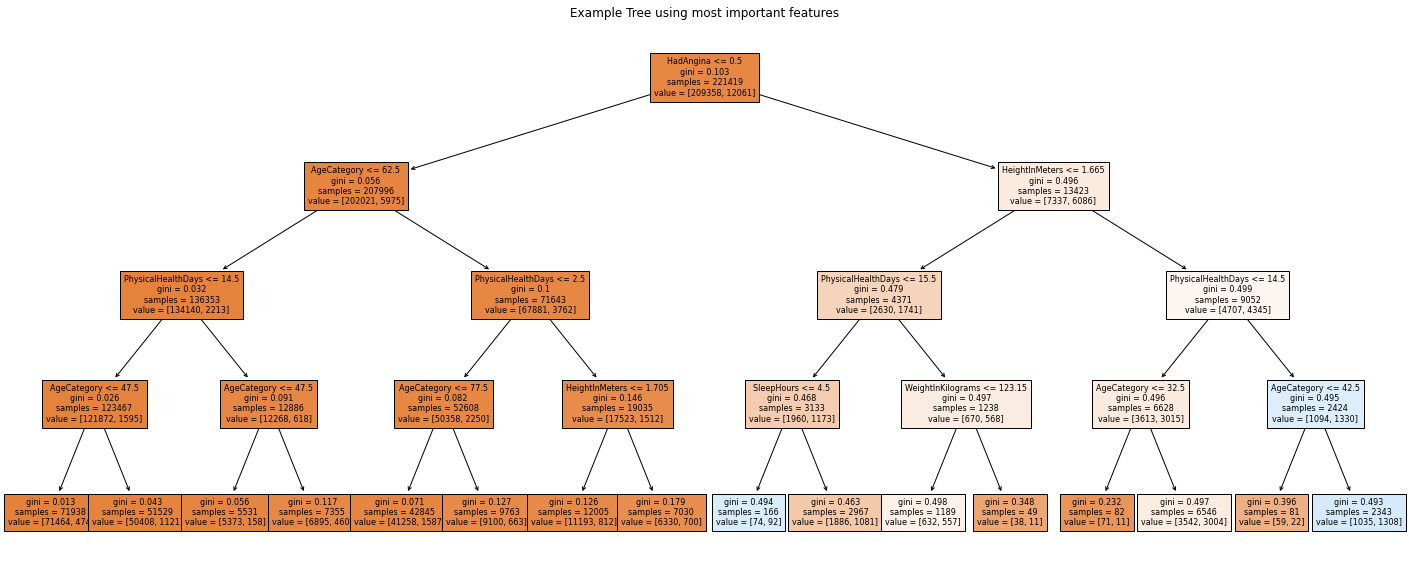

In [18]:
plt.figure(figsize=(25, 10))
plot_tree(tree.DecisionTreeClassifier(max_depth=4).fit(x_train_subset, y_train), filled=True, feature_names=important_cols, fontsize=8)
plt.title("Example Tree using most important features")
plt.show()

###### This is a visual example of a decision tree with a max depth of 4. In practice the trees have far too many nodes to display.
###### For each node, progress left if the statement is false and right if true.
###### Values are the number of samples in each category: [had heart attack, did not have heart attack]
###### Orange leaves predict no heart attack with high certainty, while the lighter colored leaves lean towards predicting heart attacks.

##### Try different tree parameters

In [19]:
# Use Entropy instead of gini
clf_entropy = tree.DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=25000, max_depth=50).fit(x_train, y_train)
print("Predictions using entropy test set")
tree_stats = compare(clf_entropy.predict(x_test), y_test)

print("\nPredictions using entropy on training set")
tree_stats = compare(clf_entropy.predict(x_train), y_train)

Predictions using entropy test set
Correct predicted heart attack: 435 out of 1374 (31.66%)
Correctly predicted no heart attack: 22220 out of 23229 (95.66%)
Total: 22655 out of 24603 (92.08%)

Predictions using entropy on training set
Correct predicted heart attack: 12042 out of 12061 (99.84%)
Correctly predicted no heart attack: 209358 out of 209358 (100.00%)
Total: 221400 out of 221419 (99.99%)


In [20]:
# Log loss
clf_log = tree.DecisionTreeClassifier(criterion="log_loss", max_leaf_nodes=25000, max_depth=50).fit(x_train, y_train)
print("Predictions using log loss on test set")
tree_stats = compare(clf_log.predict(x_test), y_test)

print("\nPredictions using log loss on training set")
tree_stats = compare(clf_log.predict(x_train), y_train)

Predictions using log loss on test set
Correct predicted heart attack: 432 out of 1374 (31.44%)
Correctly predicted no heart attack: 22225 out of 23229 (95.68%)
Total: 22657 out of 24603 (92.09%)

Predictions using log loss on training set
Correct predicted heart attack: 12042 out of 12061 (99.84%)
Correctly predicted no heart attack: 209358 out of 209358 (100.00%)
Total: 221400 out of 221419 (99.99%)


###### Changing the crition had a small impact on the results.
###### Entropy and log loss perform similarly but tend to better than gini.
######

##### Random forest

In [109]:
clf_forest = RandomForestClassifier(n_estimators=100, max_depth=40, criterion="gini", random_state=1000,
                                   bootstrap=False, n_jobs=-1,
                                    max_features=48, class_weight={0:1, 1:50}).fit(x_train, y_train)
print("Predictions using random forest on test set")
stats = compare(clf_forest.predict(x_test), y_test)

print("\nPredictions on training set")
stats = compare(clf_forest.predict(x_train), y_train)

Predictions using random forest on test set
Correct predicted heart attack: 601 out of 1374 (43.74%)
Correctly predicted no heart attack: 22019 out of 23229 (94.79%)
Total: 22620 out of 24603 (91.94%)

Predictions on training set
Correct predicted heart attack: 12061 out of 12061 (100.00%)
Correctly predicted no heart attack: 204311 out of 209358 (97.59%)
Total: 216372 out of 221419 (97.72%)


##### Parameters
###### n_estimators - having more trees does not improve accuracy.
###### Gini performed much better than entropy and log loss.
###### Each tree is trained on the entire dataset but only uses 48 of the approximately 100 columns.
###### Depth and class weight (which biases trees towards more cases where heart attack is true) help improve predicting heart attacks without impacting the accuracy of non-heart attack cases.

In [110]:
# TODO
# Use gradient boosted trees and gridsearch for hyperparameter tuning